3 1


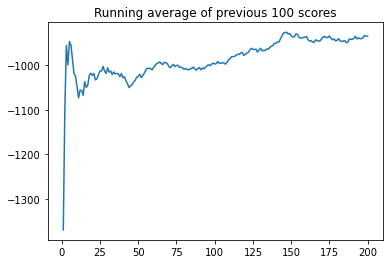

In [3]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import gym
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
t.autograd.set_detect_anomaly(True)

class Value_State(nn.Module):
    def __init__(self, dim_state, fc1, fc2, alpha=1e-3):
        super(Value_State, self).__init__()
        self.dim_state = dim_state
        self.model = nn.Sequential(nn.Linear(dim_state, fc1),
                              nn.ReLU(),
                              nn.Linear(fc1, fc2),
                              nn.ReLU(),
                              nn.Linear(fc2, 1)
                            )
        self.optimizer = optim.Adam(self.parameters(),lr=alpha, weight_decay=1e-4 )
        self.to(device)
        
    def forward(self, state):
        state = state.to(device)
        output = self.model(state)
        return output


class Actor(nn.Module):
    def __init__(self,dim_action, dim_state, fc1, fc2, min_action, max_action, alpha=1e-4, var=1):
        super(Actor, self).__init__()
        self.dim_action = dim_action
        self.dim_state = dim_state
        self.min_action = min_action
        self.max_action = max_action
        self.var = var
        self.linear1 = nn.Linear(dim_state, fc1)
        self.linear2 = nn.Linear(fc1, fc2)
        
        self.mu =nn.Linear(fc2, dim_action)
        self.sigma = nn.Linear(fc2, dim_action)
        self.to(device)
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-4 )
        
    def forward(self, state):
        output = state.to(device)
        
        output = f.relu(self.linear1(output))
        output = f.relu(self.linear2(output))
        
        mu = t.clamp(self.mu(output), self.min_action, self.max_action)
        #sigma = t.exp(self.sigma(output))
        sigma = t.tensor(self.var, dtype=t.float).to(device)
        #sigma = t.abs(t.tensor(self.min_action, dtype=t.float)) # try to use fixed std
       
        p = Normal(mu, sigma)
        action = p.sample()
        log_prob = p.log_prob(action)
        
        return action, log_prob

class Buffer():
    def __init__(self, dim_state, maxm_size):
        self.counter = 0
        
        self.states=np.zeros((maxm_size, dim_state))
        self.rewards = np.zeros(maxm_size)
        self.log_probs = np.zeros(maxm_size)
        self.states_new = np.zeros((maxm_size, dim_state))
        
        self.maxm_size = maxm_size
        
    def push(self, state, reward, log_prob, state_new):
        index = self.counter % self.maxm_size
        
        self.states[index] = state
        self.rewards[index] = reward
        self.log_probs[index] = log_prob
        self.states_new[index] = state_new
        
        self.counter+=1
        
    def clear(self):
        self.counter = 0   
        

class Agent():
    def __init__(self,env, dim_action, dim_state, fc1, fc2, alpha, \
                 min_action, max_action, max_iters=1000, elipson=0.2, rollouts=20, len_rollouts=40,epoch=10,beta=0.1, mode='clip'):
        ##########################################################
        #mode: 
        #      1: 'clip': clip version 
        #      2: 'trpo': trust region
        #      3: 'noclip': not clip version
        ##########################################################
        self.actor = Actor(dim_action, dim_state, fc1, fc2, min_action, max_action,)
        
        self.actor_current = Actor(dim_action, dim_state, fc1, fc2, min_action, max_action,)
        self.actor_current.load_state_dict(self.actor.state_dict())
        
        self.critic = Value_State(dim_state, fc1, fc2,)
        self.max_iters = max_iters
        self.env = env
        self.loss = nn.MSELoss()
        self.mode = mode
        self.elipson = elipson
        self.rollouts = rollouts
        self.len_rollouts=len_rollouts
        self.buffer = Buffer(dim_state,rollouts*len_rollouts)
        self.epoch = epoch
        self.beta = beta
        
    def select_action(self, state):
        output = t.tensor(state, dtype=t.float).to(device)
        with t.no_grad():
            action, log_prob = self.actor_current(output)
        return action.cpu().detach().numpy(), log_prob
    
    def plot_learning_curve(self,x, scores, figure_file='test'):
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(x, running_avg)
        plt.title('Running average of previous 100 scores')
        
    def rollout(self):
        for i in range(self.rollouts):
            state = self.env.reset()
            for j in range(self.len_rollouts):
                action, log_prob=self.select_action(state)
                state_new, reward, done, _ = self.env.step(action)
                self.buffer.push(state, reward, log_prob.cpu().detach().item(), state_new)
                state = state_new #Need to update the state for next action
        return 
    
    def update(self):
        self.rollout() #populate the buffer

        for i in range(self.epoch):
            for j in range(0, self.rollouts*self.len_rollouts, self.len_rollouts):   #len_rollouts as length of each batch             

                #Actor update
                _, log_pi = self.actor(t.tensor(self.buffer.states[j:j+self.len_rollouts], dtype=t.float))
                log_pi_current = t.tensor(self.buffer.log_probs[j:j+self.len_rollouts], dtype=t.float).view(-1, 1).to(device)
                ratio = t.exp(log_pi - log_pi_current)
                
                target = t.tensor(self.buffer.rewards[j:j+self.len_rollouts],dtype=t.float).view(-1, 1).to(device) + self.critic(t.tensor(self.buffer.states_new[j:j+self.len_rollouts],dtype=t.float))
                value = self.critic(t.tensor(self.buffer.states[j:j+self.len_rollouts], dtype=t.float))
                advantage = target - value
                
                if self.mode == 'clip':
                    loss_actor = -t.min(ratio, t.clamp(ratio,1-self.elipson, 1+self.elipson)) * advantage
                    loss_actor = loss_actor.mean()
                elif self.mode == 'trop': #dl(p,q) = p*log(p/q)
                    loss_actor = - (ratio*advantage - self.beta * pi_current*(log_pi_current - log_pi))
                    loss_actor = loss_actor.mean()
                elif self.mode =='noclip':                    
                    loss_actor = (-ratio * advantage).mean()
                else:
                    raise ValueError("You need to porvide a valid mode: clip, trop, noclip")
                                
                self.actor.optimizer.zero_grad()
                loss_actor.backward(retain_graph=False)                
                self.actor.optimizer.step()
                            
                #Critic update
                target = t.tensor(self.buffer.rewards[j:j+self.len_rollouts],dtype=t.float).view(-1, 1).to(device) + self.critic(t.tensor(self.buffer.states_new[j:j+self.len_rollouts],dtype=t.float))
                value = self.critic(t.tensor(self.buffer.states[j:j+self.len_rollouts], dtype=t.float))
                advantage = target - value
                loss_critic = self.loss(target, value)
                
                self.critic.optimizer.zero_grad()
                loss_critic.backward(retain_graph=False)
                self.critic.optimizer.step()     
        
        self.actor_current.load_state_dict(self.actor.state_dict())        
        self.buffer.clear()
        return 

        
    def train(self):     
        reward_list= []
        for i in range(self.max_iters):
            state = self.env.reset()
            done = False
            total_reward= 0
            self.update()
             
            while not done:
                action, _ = self.select_action(state)
                state_new, reward, done, _ = self.env.step(action)
                total_reward+=reward
            
            if i % 50 ==0:
                #print(total_reward)
                pass
            reward_list.append(total_reward)
            #self.actor_current.load_state_dict(self.actor.state_dict())
        x = [i+1 for i in range(self.max_iters)]
        self.plot_learning_curve(x, reward_list)

if __name__ == '__main__':
    env = gym.make('Pendulum-v1')
    #env = gym.make('MountainCarContinuous-v0')
    dim_state = env.observation_space.shape[0]
    dim_action = env.action_space.shape[0]
    min_action = env.action_space.low[0]
    max_action = env.action_space.high[0]

    print (dim_state,dim_action )
    #env, dim_action, dim_state, fc1, fc2, alpha=1e-3,min_action, max_action, max_iters=1000, elipson=0.2, rollouts=50, len_rollouts=40,epoch=10,beta=0.1, mode='clip'):
    agent = Agent(env, dim_action, dim_state, 30, 20,2.5e-4, min_action, max_action, max_iters=200, rollouts=10, len_rollouts=40, mode='clip' )
    agent.train()
           

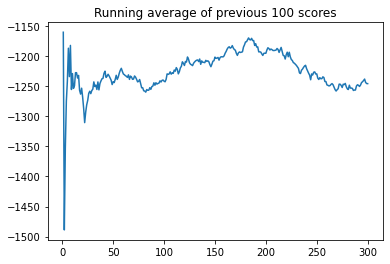

In [5]:
import torch.nn as nn
import torch 
import torch.optim as optim
import torch.nn.functional as F
import gym
import numpy as np
import matplotlib.pyplot as plt

dq=False
max_iters = 300


rewards_list=[]
for i in range(max_iters):

    state = env.reset()
    done=False
    rewards = 0
    
    while not done:
        if dq:
            actions = model(torch.tensor(state).float())
            best = torch.argmax(actions)               
            action = agent.select_actions_epsilon(best.item())
        else:
            action = env.action_space.sample()
        
        state_new, reward, done, _ = env.step(action)
        rewards+=reward
        
        state = state_new
        
    rewards_list.append(rewards)
#print(rewards_list)           
x = [i+1 for i in range(max_iters)]
agent.plot_learning_curve(x, rewards_list)

In [1]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import gym
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt

device = t.device('cpu' if t.cuda.is_available() else 'cpu')
t.autograd.set_detect_anomaly(True)

class Value_State(nn.Module):
    def __init__(self, dim_state, fc1, fc2, alpha=1e-3):
        super(Value_State, self).__init__()
        self.dim_state = dim_state
        self.model = nn.Sequential(nn.Linear(dim_state, fc1),
                              nn.ReLU(),
                              nn.Linear(fc1, fc2),
                              nn.ReLU(),
                              nn.Linear(fc2, 1)
                            )
        self.optimizer = optim.Adam(self.parameters(),lr=alpha, weight_decay=1e-4 )
        self.to(device)
        
    def forward(self, state):
        state = state.to(device)
        output = self.model(state)
        return output


class Actor(nn.Module):
    def __init__(self,dim_action, dim_state, fc1, fc2, min_action, max_action, alpha=1e-4, var=1):
        super(Actor, self).__init__()
        self.dim_action = dim_action
        self.dim_state = dim_state
        self.min_action = min_action
        self.max_action = max_action
        self.var = var
        self.linear1 = nn.Linear(dim_state, fc1)
        self.linear2 = nn.Linear(fc1, fc2)
        
        self.mu =nn.Linear(fc2, dim_action)
        self.sigma = nn.Linear(fc2, dim_action)
        self.to(device)
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-4 )
        
    def forward(self, state):
        output = state.to(device)
        
        output = f.relu(self.linear1(output))
        output = f.relu(self.linear2(output))
        
        mu = t.clamp(self.mu(output), self.min_action, self.max_action)
        #sigma = t.exp(self.sigma(output))
        sigma = t.tensor(self.var, dtype=t.float)
        #sigma = t.abs(t.tensor(self.min_action, dtype=t.float)) # try to use fixed std
       
        p = MultivariateNormal(mu, sigma)
        action = p.sample()
        log_prob = p.log_prob(action)
        
        return action, log_prob

class Buffer():
    def __init__(self, dim_state, maxm_size):
        self.counter = 0
        
        self.states=np.zeros((maxm_size, dim_state))
        self.rewards = np.zeros(maxm_size)
        self.log_probs = np.zeros(maxm_size)
        self.states_new = np.zeros((maxm_size, dim_state))
        
        self.maxm_size = maxm_size
        
    def push(self, state, reward, log_prob, state_new):
        index = self.counter % self.maxm_size
        
        self.states[index] = state
        self.rewards[index] = reward
        self.log_probs[index] = log_prob
        self.states_new[index] = state_new
        
        self.counter+=1
        
    def clear(self):
        self.counter = 0   
        

class Agent():
    def __init__(self,env, dim_action, dim_state, fc1, fc2, alpha, \
                 min_action, max_action, max_iters=1000, elipson=0.2, rollouts=20, len_rollouts=40,epoch=10,beta=0.1, mode='clip'):
        ##########################################################
        #mode: 
        #      1: 'clip': clip version 
        #      2: 'trpo': trust region
        #      3: 'noclip': not clip version
        ##########################################################
        self.actor = Actor(dim_action, dim_state, fc1, fc2, min_action, max_action,)
        
        self.actor_current = Actor(dim_action, dim_state, fc1, fc2, min_action, max_action,)
        self.actor_current.load_state_dict(self.actor.state_dict())
        
        self.critic = Value_State(dim_state, fc1, fc2,)
        self.max_iters = max_iters
        self.env = env
        self.loss = nn.MSELoss()
        self.mode = mode
        self.elipson = elipson
        self.rollouts = rollouts
        self.len_rollouts=len_rollouts
        self.buffer = Buffer(dim_state,rollouts*len_rollouts)
        self.epoch = epoch
        self.beta = beta
        
    def select_action(self, state):
        output = t.tensor(state, dtype=t.float).to(device)
        with t.no_grad():
            action, log_prob = self.actor_current(output)
        return action.cpu().detach().numpy(), log_prob
    
    def plot_learning_curve(self,x, scores, figure_file='test'):
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(x, running_avg)
        plt.title('Running average of previous 100 scores')
        
    def rollout(self):
        for i in range(self.rollouts):
            state = self.env.reset()
            for j in range(self.len_rollouts):
                action, log_prob=self.select_action(state)
                state_new, reward, done, _ = self.env.step(action)
                print(log_prob)
                self.buffer.push(state, reward, log_prob.cpu().detach().item(), state_new)
                state = state_new #Need to update the state for next action
        return 
    
    def update(self):
        self.rollout() #populate the buffer

        for i in range(self.epoch):
            for j in range(0, self.rollouts*self.len_rollouts, self.len_rollouts):   #len_rollouts as length of each batch             

                #Actor update
                _, log_pi = self.actor(t.tensor(self.buffer.states[j:j+self.len_rollouts], dtype=t.float))
                log_pi_current = t.tensor(self.buffer.log_probs[j:j+self.len_rollouts], dtype=t.float).view(-1, 1) 
                ratio = t.exp(log_pi - log_pi_current)
                
                target = t.tensor(self.buffer.rewards[j:j+self.len_rollouts],dtype=t.float).view(-1, 1) + self.critic(t.tensor(self.buffer.states_new[j:j+self.len_rollouts],dtype=t.float))
                value = self.critic(t.tensor(self.buffer.states[j:j+self.len_rollouts], dtype=t.float))
                advantage = target - value
                
                if self.mode == 'clip':
                    loss_actor = -t.min(ratio, t.clamp(ratio,1-self.elipson, 1+self.elipson)) * advantage
                    loss_actor = loss_actor.mean()
                elif self.mode == 'trop': #dl(p,q) = p*log(p/q)
                    loss_actor = - (ratio*advantage - self.beta * pi_current*(log_pi_current - log_pi))
                    loss_actor = loss_actor.mean()
                elif self.mode =='noclip':                    
                    loss_actor = (-ratio * advantage).mean()
                else:
                    raise ValueError("You need to porvide a valid mode: clip, trop, noclip")
                                
                self.actor.optimizer.zero_grad()
                loss_actor.backward(retain_graph=False)                
                self.actor.optimizer.step()
                            
                #Critic update
                target = t.tensor(self.buffer.rewards[j:j+self.len_rollouts],dtype=t.float).view(-1, 1) + self.critic(t.tensor(self.buffer.states_new[j:j+self.len_rollouts],dtype=t.float))
                value = self.critic(t.tensor(self.buffer.states[j:j+self.len_rollouts], dtype=t.float))
                advantage = target - value
                loss_critic = self.loss(target, value)
                
                self.critic.optimizer.zero_grad()
                loss_critic.backward(retain_graph=False)
                self.critic.optimizer.step()     
        
        self.actor_current.load_state_dict(self.actor.state_dict())        
        self.buffer.clear()
        return 

        
    def train(self):     
        reward_list= []
        for i in range(self.max_iters):
            state = self.env.reset()
            done = False
            total_reward= 0
            self.update()
             
            while not done:
                action, _ = self.select_action(state)
                state_new, reward, done, _ = self.env.step(state)
                total_reward+=reward
            
            if i % 50 ==0:
                #print(total_reward)
                pass
            reward_list.append(total_reward)
            #self.actor_current.load_state_dict(self.actor.state_dict())
        x = [i+1 for i in range(self.max_iters)]
        self.plot_learning_curve(x, reward_list)
from supplychain import SimpleSupplyChain
if __name__ == '__main__':
    #env = gym.make('Pendulum-v1')
    #env = gym.make('MountainCarContinuous-v0')
    env = SimpleSupplyChain()
    dim_state = env.observation_space.shape[0]
    dim_action = env.action_space.shape[0]
    min_action = env.action_space.low[0]
    max_action = env.action_space.high[0]

    print (dim_state,dim_action )
    #env, dim_action, dim_state, fc1, fc2, alpha=1e-3,min_action, max_action, max_iters=1000, elipson=0.2, rollouts=20, len_rollouts=40,epoch=10,beta=0.1, mode='clip'):
    agent = Agent(env, dim_action, dim_state, 300, 200,5.5e-3, min_action, max_action, max_iters=200, mode='clip' )
    agent.train()

17 4


ValueError: covariance_matrix must be at least two-dimensional, with optional leading batch dimensions